In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore', category=FutureWarning)



In [194]:
# Load the dataset
data = pd.read_csv('/Users/ayush/features_3_sec.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(kernel='rbf'),
    'Naive Bayes': GaussianNB(),
    'kNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

a_list=[]
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    accuracy = accuracy_score(y_true, y_pred)
    
    
    tpr = TP / (TP + FN)
    tnr = TN / (TN + FP)

    return {'Accuracy': accuracy, 'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN, 'TPR': tpr, 'TNR': tnr}

# Train and evaluate classifiers
results = {}
results_dict = {}
for name, clf in classifiers.items():
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    metrics = calculate_metrics(y_test, y_pred)
    results[name] = metrics
    accuracy = metrics['Accuracy']
    
#     if name != 'Logistic Regression':
    results_dict[name] = accuracy

# Print results in a table
print(f"{'Classifier':<30} {'Accuracy':<10} {'TP':<5} {'FP':<5} {'TN':<5} {'FN':<5} {'TPR':<5} {'TNR':<5}")
print("-" * 72)
for name, metrics in results.items():
    print(f"{name:<30} {metrics['Accuracy']:<10.4f} {metrics['TP']:<5} {metrics['FP']:<5} {metrics['TN']:<5} {metrics['FN']:<5} {metrics['TPR']:<5.4f} {metrics['TNR']:<5.4f}")


Classifier                     Accuracy   TP    FP    TN    FN    TPR   TNR  
------------------------------------------------------------------------
Logistic Regression            0.8619     187   1     187   3     0.9842 0.9947
Decision Tree                  0.7788     178   9     158   5     0.9727 0.9461
SVM                            0.9259     194   3     204   2     0.9898 0.9855
Naive Bayes                    0.7097     182   12    117   4     0.9785 0.9070
kNN                            0.9419     191   1     207   3     0.9845 0.9952
Random Forest                  0.9229     189   3     206   3     0.9844 0.9856
LDA                            0.8208     183   7     174   1     0.9946 0.9613
QDA                            0.8809     187   1     195   2     0.9894 0.9949


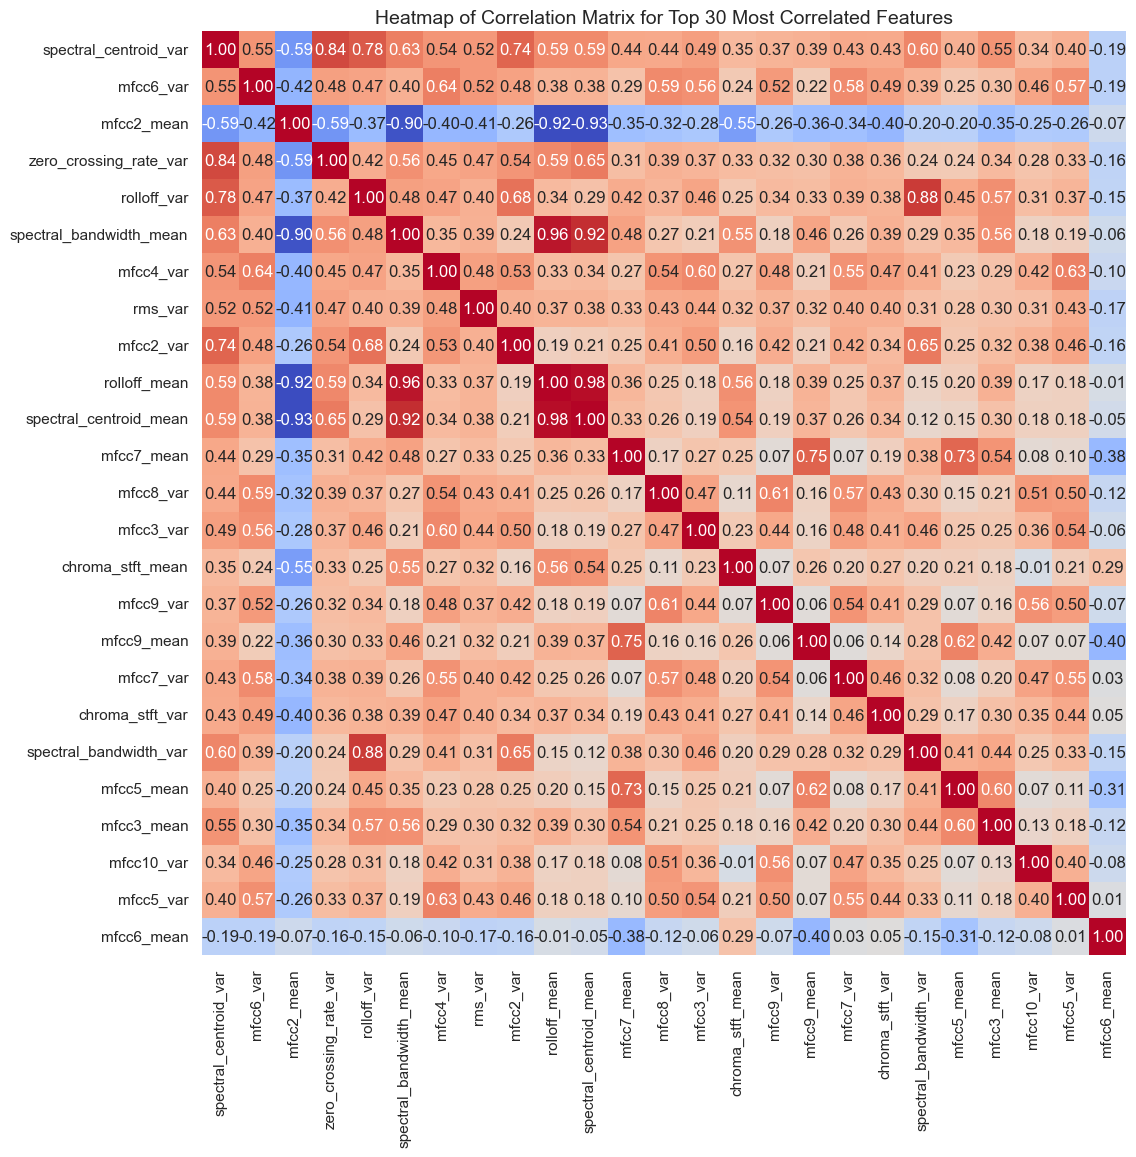

In [242]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the dataset
corr_matrix = data.corr()

# Get the absolute values of the correlation matrix
abs_corr_matrix = np.abs(corr_matrix)

# Get the 30 most correlated features by summing the absolute values of correlations and sorting them
top_30_corr_features = abs_corr_matrix.sum().sort_values(ascending=False).head(25).index

# Calculate the correlation matrix for the top 30 correlated features
top_30_corr_matrix = data[top_30_corr_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(top_30_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=False, square=True)
plt.title('Heatmap of Correlation Matrix for Top 30 Most Correlated Features', fontsize=14)
plt.show()


In [195]:
results_dict = {k: round(v, 2) for k, v in results_dict.items()}
results_dict = {k: v for k, v in sorted(results_dict.items())}

hyper_dict = {}
# Store the selected features in a list

feature_names = data.columns.tolist()
len(feature_names)

54

In [129]:
# Logistic Regression classifier
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

# RFE for feature selection
num_features_to_select = [53]  # list of feature numbers to try
rfe = RFE(logreg)
highest_acc = 0
best_num_features = 0
selected_features = []

# Cross-validation for RFE feature selection
for num_features in num_features_to_select:
    rfe.n_features_to_select = num_features
    cv_scores = cross_val_score(rfe, X_train, y_train, cv=5)
    mean_acc = np.mean(cv_scores)
    
    if mean_acc > highest_acc:
        highest_acc = mean_acc
        best_num_features = num_features
        rfe.fit(X_train, y_train)
        selected_features = rfe.support_

print(f"Best number of features to select: {best_num_features}")

# Logistic Regression hyperparameter tuning with GridSearchCV
param_grid = {'C': np.logspace(-4, 4, 20)}  # Define the range of C values to search
grid_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_logreg.fit(X_train[:, selected_features], y_train)

# Print the best hyperparameters for Logistic Regression
print("Best hyperparameters for Logistic Regression:", grid_logreg.best_params_)

# Train and evaluate the Logistic Regression classifier with the best hyperparameters and selected features
clf_logreg = LogisticRegression(**grid_logreg.best_params_, solver='liblinear', max_iter=1000)
clf_logreg.fit(X_train[:, selected_features], y_train)
y_pred_logreg = clf_logreg.predict(X_test[:, selected_features])
acc_logreg = accuracy_score(y_test, y_pred_logreg)
cr_logreg = classification_report(y_test, y_pred_logreg)

print("Logistic Regression accuracy after RFE feature selection and hyperparameter tuning:", acc_logreg)

# Store the selected features in a list
feature_names = np.array(data.columns[:-1])
selected_features_logreg = feature_names[selected_features].tolist()


Best number of features to select: 53
Best hyperparameters for Logistic Regression: {'C': 29.763514416313132}
Logistic Regression accuracy after RFE feature selection and hyperparameter tuning: 0.8558558558558559


In [196]:
len(selected_features_logreg)

53

In [133]:
# Decision Tree classifier
dt = DecisionTreeClassifier()

# RFE for feature selection
num_features_to_select = [5, 10, 15, 20,30]  # list of feature numbers to try
rfe = RFE(dt)
highest_acc = 0
best_num_features = 0
selected_features_DT = []

# Cross-validation for RFE feature selection
for num_features in num_features_to_select:
    rfe.n_features_to_select = num_features
    cv_scores = cross_val_score(rfe, X_train, y_train, cv=5)
    mean_acc = np.mean(cv_scores)
    
    if mean_acc > highest_acc:
        highest_acc = mean_acc
        best_num_features = num_features
        rfe.fit(X_train, y_train)
        selected_features = rfe.support_

print(f"Best number of features to select: {best_num_features}")

# Print the selected feature names
selected_features_DT = [feature for feature, selected in zip(feature_names, selected_features) if selected]


# Decision Tree hyperparameter tuning
param_grid_dt = {'max_depth': [5, 10, 20],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_dt.fit(X_train[:, selected_features], y_train)

# Print the best hyperparameters for Decision Tree
print("Best hyperparameters for Decision Tree:", grid_dt.best_params_)

# Train and evaluate the Decision Tree classifier with the best hyperparameters and selected features
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train[:, selected_features], y_train)
y_pred_dt = clf_dt.predict(X_test[:, selected_features])
acc_dt = accuracy_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cr_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree accuracy after RFE feature selection and hyperparameter tuning:", acc_dt)
print("Decision Tree confusion matrix:\n", cm_dt)
print("Decision Tree classification report:\n", cr_dt)


Best number of features to select: 30
Best hyperparameters for Decision Tree: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree accuracy after RFE feature selection and hyperparameter tuning: 0.7787787787787788
Decision Tree confusion matrix:
 [[158  10  13   0  32]
 [  7 175   1   3  13]
 [ 14   0 145  20  11]
 [  2   2  15 171  15]
 [ 27   6  18  12 129]]
Decision Tree classification report:
               precision    recall  f1-score   support

       blues       0.76      0.74      0.75       213
   classical       0.91      0.88      0.89       199
      hiphop       0.76      0.76      0.76       190
         pop       0.83      0.83      0.83       205
        rock       0.65      0.67      0.66       192

    accuracy                           0.78       999
   macro avg       0.78      0.78      0.78       999
weighted avg       0.78      0.78      0.78       999



In [198]:
len(selected_features_DT)

30

In [213]:

# Feature selection using Mutual Information
k = 30  # Number of top features to select
selector_mi = SelectKBest(mutual_info_classif, k=k)
X_train_mi = selector_mi.fit_transform(X_train, y_train)
X_test_mi = selector_mi.transform(X_test)

# Feature selection using RFE
svm_rfe = SVC(kernel='linear')  # Linear kernel is recommended for RFE
selector_rfe = RFE(svm_rfe, n_features_to_select=k)
X_train_rfe = selector_rfe.fit_transform(X_train_mi, y_train)
X_test_rfe = selector_rfe.transform(X_test_mi)

# Support Vector Machines (SVM) hyperparameter tuning
svm = SVC()
param_grid_svm = {'C': [0.1, 1, 10],
                  'kernel': ['linear', 'rbf'],
                  'gamma': ['scale', 'auto']}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train_rfe, y_train)

# Print the best hyperparameters for SVM
print("Best hyperparameters for SVM:", grid_svm.best_params_)

# Train and evaluate the SVM classifier with the best hyperparameters
clf_svm = SVC(**grid_svm.best_params_)
clf_svm.fit(X_train_rfe, y_train)
y_pred_svm = clf_svm.predict(X_test_rfe)
acc_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cr_svm = classification_report(y_test, y_pred_svm)
print("SVM accuracy after feature selection and hyperparameter tuning:", acc_svm)
print("SVM confusion matrix:\n", cm_svm)
print("SVM classification report:\n", cr_svm)

# Get the selected features after Mutual Information
selected_features_mi = data.columns[:-1][selector_mi.get_support()]

# Get the selected features after RFE
selected_features_rfe = selected_features_mi[selector_rfe.get_support()]

# Convert selected_features_rfe to a list
selected_features_SVM = selected_features_rfe.tolist()

# Print the selected features
print("Selected features after Mutual Information and RFE:")



Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM accuracy after feature selection and hyperparameter tuning: 0.9319319319319319
SVM confusion matrix:
 [[201   3   1   0   8]
 [  2 195   0   1   1]
 [  6   0 176   6   2]
 [  0   1   7 186  11]
 [  6   0   8   5 173]]
SVM classification report:
               precision    recall  f1-score   support

       blues       0.93      0.94      0.94       213
   classical       0.98      0.98      0.98       199
      hiphop       0.92      0.93      0.92       190
         pop       0.94      0.91      0.92       205
        rock       0.89      0.90      0.89       192

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999

Selected features after Mutual Information and RFE:


In [199]:
len(selected_features_SVM)

30

In [212]:

from sklearn.ensemble import RandomForestClassifier



# Feature selection using RFE with a RandomForestClassifier with default hyperparameters
rf_clf = RandomForestClassifier(random_state=42)
rfe_selector = RFE(rf_clf, n_features_to_select=25, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train)
X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

# Print the selected features
selected_features_RF = list(data.columns[:-1][rfe_selector.support_])

# Perform hyperparameter tuning on the selected features using GridSearchCV
param_grid_rf = {'n_estimators': [100, 200, 500],
                 'max_depth': [5, 10, 20],
                 'min_samples_leaf': [1, 2, 4]}
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5)
grid_rf.fit(X_train_rfe, y_train)

# Print the best hyperparameters for Random Forest
print("Best hyperparameters for Random Forest:", grid_rf.best_params_)

# Train and evaluate the RandomForestClassifier with the best hyperparameters and selected features
clf_rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
clf_rf.fit(X_train_rfe, y_train)
y_pred_rf = clf_rf.predict(X_test_rfe)
acc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cr_rf = classification_report(y_test, y_pred_rf)

print("Random Forest accuracy after hyperparameter tuning and RFE feature selection:", acc_rf)
print("Random Forest confusion matrix:\n", cm_rf)
print("Random Forest classification report:\n", cr_rf)


Best hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}
Random Forest accuracy after hyperparameter tuning and RFE feature selection: 0.913913913913914
Random Forest confusion matrix:
 [[197   4   1   0  11]
 [  3 190   0   2   4]
 [  9   0 170  10   1]
 [  1   1   6 193   4]
 [ 10   3   8   8 163]]
Random Forest classification report:
               precision    recall  f1-score   support

       blues       0.90      0.92      0.91       213
   classical       0.96      0.95      0.96       199
      hiphop       0.92      0.89      0.91       190
         pop       0.91      0.94      0.92       205
        rock       0.89      0.85      0.87       192

    accuracy                           0.91       999
   macro avg       0.91      0.91      0.91       999
weighted avg       0.91      0.91      0.91       999



In [200]:
len(selected_features_RF)

25

In [207]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Feature selection using RFE
lda = LinearDiscriminantAnalysis()
rfe = RFE(lda, n_features_to_select=36)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Hyperparameter tuning
param_grid_lda = {'solver': ['lsqr', 'eigen'],
                  'shrinkage': ['auto', None]}
grid_lda = GridSearchCV(lda, param_grid_lda, cv=5)
grid_lda.fit(X_train_rfe, y_train)

# Print the best hyperparameters for LDA
print("Best hyperparameters for LDA:", grid_lda.best_params_)

# Train and evaluate the LDA classifier with the best hyperparameters
clf_lda = LinearDiscriminantAnalysis(**grid_lda.best_params_)
clf_lda.fit(X_train_rfe, y_train)
y_pred_lda = clf_lda.predict(X_test_rfe)
acc_lda = accuracy_score(y_test, y_pred_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda)
cr_lda = classification_report(y_test, y_pred_lda)

print("Linear Discriminant Analysis accuracy after feature selection and hyperparameter tuning:", acc_lda)
print("Linear Discriminant Analysis confusion matrix:\n", cm_lda)
print("Linear Discriminant Analysis classification report:\n", cr_lda)

# Store the selected features
selected_features_LDA = [column for column, selected in zip(data.columns[:-1], rfe.support_) if selected]


Best hyperparameters for LDA: {'shrinkage': None, 'solver': 'lsqr'}
Linear Discriminant Analysis accuracy after feature selection and hyperparameter tuning: 0.8108108108108109
Linear Discriminant Analysis confusion matrix:
 [[172   7   4   0  30]
 [  2 183   2   0  12]
 [ 11   0 142  20  17]
 [  1   3  12 182   7]
 [ 28   5  13  15 131]]
Linear Discriminant Analysis classification report:
               precision    recall  f1-score   support

       blues       0.80      0.81      0.81       213
   classical       0.92      0.92      0.92       199
      hiphop       0.82      0.75      0.78       190
         pop       0.84      0.89      0.86       205
        rock       0.66      0.68      0.67       192

    accuracy                           0.81       999
   macro avg       0.81      0.81      0.81       999
weighted avg       0.81      0.81      0.81       999



In [201]:
len(selected_features_LDA)

36

In [206]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Feature selection using Mutual Information
k_mi = 38
selector_mi = SelectKBest(mutual_info_classif, k=k_mi)
X_train_mi = selector_mi.fit_transform(X_train, y_train)
X_test_mi = selector_mi.transform(X_test)

# Feature selection using ANOVA F-value
k_f = 38
selector_f = SelectKBest(f_classif, k=k_f)
X_train_f = selector_f.fit_transform(X_train, y_train)
X_test_f = selector_f.transform(X_test)

# Hyperparameter tuning for QDA
qda = QuadraticDiscriminantAnalysis()
param_grid_qda = {'reg_param': [0.0, 0.1, 0.2]}
grid_qda_mi = GridSearchCV(qda, param_grid_qda, cv=5)
grid_qda_f = GridSearchCV(qda, param_grid_qda, cv=5)

# Fit QDA with Mutual Information and ANOVA F-value feature selection
grid_qda_mi.fit(X_train_mi, y_train)
grid_qda_f.fit(X_train_f, y_train)

# Choose the best performing feature selection method
if grid_qda_mi.best_score_ > grid_qda_f.best_score_:
    best_qda = grid_qda_mi
    selector = selector_mi
    X_train_selected = X_train_mi
    X_test_selected = X_test_mi
    print("Best feature selection method for QDA: Mutual Information")
else:
    best_qda = grid_qda_f
    selector = selector_f
    X_train_selected = X_train_f
    X_test_selected = X_test_f
    print("Best feature selection method for QDA: ANOVA F-value")

# Print the best hyperparameters for QDA
print("Best hyperparameters for QDA:", best_qda.best_params_)

# Train and evaluate QDA with the best hyperparameters
clf_qda = QuadraticDiscriminantAnalysis(**best_qda.best_params_)
clf_qda.fit(X_train_selected, y_train)
y_pred_qda = clf_qda.predict(X_test_selected)
acc_qda = accuracy_score(y_test, y_pred_qda)
cm_qda = confusion_matrix(y_test, y_pred_qda)
cr_qda = classification_report(y_test, y_pred_qda)
print("Quadratic Discriminant Analysis accuracy after feature selection and hyperparameter tuning:", acc_qda)
print("Quadratic Discriminant Analysis confusion matrix:\n", cm_qda)
print("Quadratic Discriminant Analysis classification report:\n", cr_qda)

# Store the selected features in a list
selected_features_QDA = [col for col, selected in zip(data.columns[:-1], selector.get_support()) if selected]



Best feature selection method for QDA: Mutual Information
Best hyperparameters for QDA: {'reg_param': 0.0}
Quadratic Discriminant Analysis accuracy after feature selection and hyperparameter tuning: 0.8808808808808809
Quadratic Discriminant Analysis confusion matrix:
 [[198   3   0   0  12]
 [  0 189   3   1   6]
 [  8   0 145  19  18]
 [  0   2   3 188  12]
 [ 14   3   3  12 160]]
Quadratic Discriminant Analysis classification report:
               precision    recall  f1-score   support

       blues       0.90      0.93      0.91       213
   classical       0.96      0.95      0.95       199
      hiphop       0.94      0.76      0.84       190
         pop       0.85      0.92      0.88       205
        rock       0.77      0.83      0.80       192

    accuracy                           0.88       999
   macro avg       0.88      0.88      0.88       999
weighted avg       0.89      0.88      0.88       999



In [202]:
len(selected_features_QDA)

38

In [10]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Feature selection using Mutual Information
k = 30  # Number of top features to select
selector_mi = SelectKBest(mutual_info_classif, k=k)
X_train_mi = selector_mi.fit_transform(X_train, y_train)
X_test_mi = selector_mi.transform(X_test)

# Feature selection using ANOVA-F
selector_f = SelectKBest(f_classif, k=k)
X_train_f = selector_f.fit_transform(X_train, y_train)
X_test_f = selector_f.transform(X_test)

# Gaussian Naive Bayes hyperparameter tuning
gnb = GaussianNB()
param_grid_gnb = {'var_smoothing': np.logspace(0, -9, num=100)}
grid_gnb_mi = GridSearchCV(gnb, param_grid_gnb, cv=5)
grid_gnb_mi.fit(X_train_mi, y_train)

grid_gnb_f = GridSearchCV(gnb, param_grid_gnb, cv=5)
grid_gnb_f.fit(X_train_f, y_train)

# Determine the best feature selection method based on the best score
if grid_gnb_mi.best_score_ > grid_gnb_f.best_score_:
    best_fs_method = 'Mutual Information'
    best_fs_selector = selector_mi
    X_train_fs = X_train_mi
    X_test_fs = X_test_mi
    grid_gnb = grid_gnb_mi
else:
    best_fs_method = 'ANOVA-F'
    best_fs_selector = selector_f
    X_train_fs = X_train_f
    X_test_fs = X_test_f
    grid_gnb = grid_gnb_f

# Print the best hyperparameters for Gaussian Naive Bayes
print("Best hyperparameters for Gaussian Naive Bayes:", grid_gnb.best_params_)

# Train and evaluate the Gaussian Naive Bayes classifier with the best hyperparameters and feature selection method
clf_gnb = GaussianNB(**grid_gnb.best_params_)
clf_gnb.fit(X_train_fs, y_train)
y_pred_gnb = clf_gnb.predict(X_test_fs)
acc_gnb = accuracy_score(y_test, y_pred_gnb)
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
cr_gnb = classification_report(y_test, y_pred_gnb)

print(f"Best feature selection method: {best_fs_method}")
print("Gaussian Naive Bayes accuracy after feature selection and hyperparameter tuning:", acc_gnb)
print("Gaussian Naive Bayes confusion matrix:\n", cm_gnb)
print("Gaussian Naive Bayes classification report:\n", cr_gnb)

# Store the selected features in a list
feature_names = data.columns.tolist()
selected_features_NB = [feature_names[i] for i in best_fs_selector.get_support(indices=True)]

Best hyperparameters for Gaussian Naive Bayes: {'var_smoothing': 0.012328467394420659}
Best feature selection method: Mutual Information
Gaussian Naive Bayes accuracy after feature selection and hyperparameter tuning: 0.7037037037037037
Gaussian Naive Bayes confusion matrix:
 [[126  18   4   0  65]
 [  3 188   2   0   6]
 [ 17   0  91  45  37]
 [  1   3   7 181  13]
 [ 28   9   7  31 117]]
Gaussian Naive Bayes classification report:
               precision    recall  f1-score   support

       blues       0.72      0.59      0.65       213
   classical       0.86      0.94      0.90       199
      hiphop       0.82      0.48      0.60       190
         pop       0.70      0.88      0.78       205
        rock       0.49      0.61      0.54       192

    accuracy                           0.70       999
   macro avg       0.72      0.70      0.70       999
weighted avg       0.72      0.70      0.70       999



In [203]:
len(selected_features_NB)

30

In [211]:

# Feature selection using Mutual Information
k = 30  # Number of top features to select
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_mi = selector_mi.fit_transform(X_train, y_train)
X_test_mi = selector_mi.transform(X_test)

# Feature selection using ANOVA-F
selector_f = SelectKBest(score_func=f_classif, k=k)
X_train_f = selector_f.fit_transform(X_train, y_train)
X_test_f = selector_f.transform(X_test)

# kNN hyperparameter tuning with Mutual Information feature selection
knn = KNeighborsClassifier()
param_grid_knn_mi = {'n_neighbors': np.arange(1, 21)}
grid_knn_mi = GridSearchCV(knn, param_grid_knn_mi, cv=5)
grid_knn_mi.fit(X_train_mi, y_train)

# kNN hyperparameter tuning with ANOVA-F feature selection
knn = KNeighborsClassifier()
param_grid_knn_f = {'n_neighbors': np.arange(1, 21)}
grid_knn_f = GridSearchCV(knn, param_grid_knn_f, cv=5)
grid_knn_f.fit(X_train_f, y_train)

# Determine the best feature selection method based on the best score
if grid_knn_mi.best_score_ > grid_knn_f.best_score_:
    best_fs_method = 'Mutual Information'
    best_fs_selector = selector_mi
    X_train_fs = X_train_mi
    X_test_fs = X_test_mi
    grid_knn = grid_knn_mi
else:
    best_fs_method = 'ANOVA-F'
    best_fs_selector = selector_f
    X_train_fs = X_train_f
    X_test_fs = X_test_f
    grid_knn = grid_knn_f

# Print the best hyperparameters for kNN
print("Best hyperparameters for kNN:", grid_knn.best_params_)

# Train and evaluate the kNN classifier with the best hyperparameters and feature selection method
clf_knn = KNeighborsClassifier(**grid_knn.best_params_)
clf_knn.fit(X_train_fs, y_train)
y_pred_knn = clf_knn.predict(X_test_fs)
acc_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cr_knn = classification_report(y_test, y_pred_knn)

print(f"Best feature selection method: {best_fs_method}")
print("kNN accuracy after feature selection and hyperparameter tuning:", acc_knn)
print("kNN confusion matrix:\n", cm_knn)
print("kNN classification report:\n", cr_knn)

# Store the selected features in a list
selected_features_KNN = [feature_names[i] for i in best_fs_selector.get_support(indices=True)]


Best hyperparameters for kNN: {'n_neighbors': 1}
Best feature selection method: ANOVA-F
kNN accuracy after feature selection and hyperparameter tuning: 0.955955955955956
kNN confusion matrix:
 [[206   1   4   0   2]
 [  1 195   0   2   1]
 [  4   0 177   7   2]
 [  0   1   6 196   2]
 [  5   1   0   5 181]]
kNN classification report:
               precision    recall  f1-score   support

       blues       0.95      0.97      0.96       213
   classical       0.98      0.98      0.98       199
      hiphop       0.95      0.93      0.94       190
         pop       0.93      0.96      0.94       205
        rock       0.96      0.94      0.95       192

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



In [193]:
# Load the test_features.csv file into a DataFrame
test_data = pd.read_csv('/Users/ayush/Documents/Data/Test/test_features.csv')

# Scale the test data using the same scaler as the training data
X_test_unscaled = test_data.iloc[:, :-1].values
X_test_scaled = scaler.transform(X_test_unscaled)

# Create a DataFrame with the scaled test data
test_data_scaled_df = pd.DataFrame(X_test_scaled, columns=test_data.columns[:-1])

# Extract the selected features and labels from the DataFrame
X_test_selected = test_data_scaled_df[selected_features_KNN].to_numpy()  # Convert to NumPy array
y_test_selected = test_data['label']

# Use the clf_knn classifier to make predictions on the test set
y_pred_knn = clf_knn.predict(X_test_selected)

# Calculate the accuracy, confusion matrix, and classification report
acc_knn = accuracy_score(y_test_selected, y_pred_knn)
cm_knn = confusion_matrix(y_test_selected, y_pred_knn)
cr_knn = classification_report(y_test_selected, y_pred_knn, zero_division=0)

# Print the results
print("kNN accuracy on test set:", acc_knn)
print("kNN confusion matrix:\n", cm_knn)
print("kNN classification report:\n", cr_knn)


kNN accuracy on test set: 0.6576923076923077
kNN confusion matrix:
 [[20  0 17  4 11]
 [ 1 50  0  1  0]
 [ 0  1 38 11  2]
 [ 1  1 11 26 13]
 [ 0  1  4 10 37]]
kNN classification report:
               precision    recall  f1-score   support

       blues       0.91      0.38      0.54        52
   classical       0.94      0.96      0.95        52
      hiphop       0.54      0.73      0.62        52
         pop       0.50      0.50      0.50        52
        rock       0.59      0.71      0.64        52

    accuracy                           0.66       260
   macro avg       0.70      0.66      0.65       260
weighted avg       0.70      0.66      0.65       260



In [216]:

hyper_dict = {'Decision Tree': acc_dt,'Logistic Regression': acc_logreg,'SVM': acc_svm, 'Naive Bayes': acc_gnb, 'kNN': acc_knn, 'Random Forest': acc_rf, 'LDA': acc_lda, 'QDA': acc_qda}
hyper_dict = {k: round(v, 2) for k, v in hyper_dict.items()}
hyper_dict = {k: v for k, v in sorted(hyper_dict.items())}
acc_rf

0.913913913913914

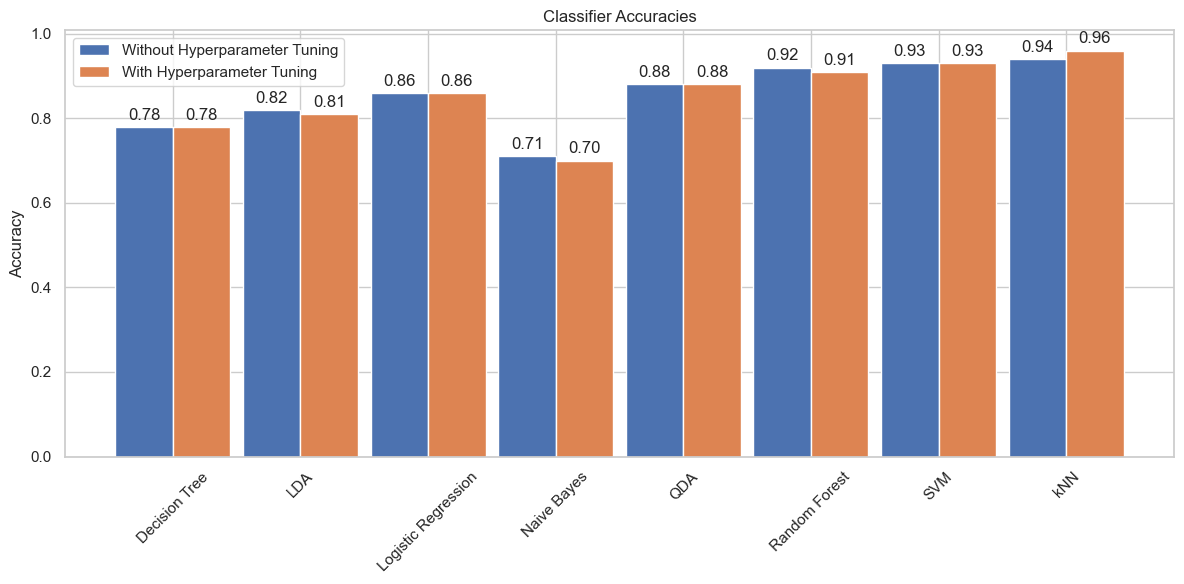

In [217]:
import matplotlib.pyplot as plt
# Get the corresponding accuracy values
keys = sorted(results_dict.keys())
results_values = [results_dict[key] for key in keys]
hyper_values = [hyper_dict[key] for key in keys]

# Set up the bar graph
bar_width = 0.45
x = np.arange(len(keys))

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - bar_width / 2, results_values, bar_width, label='Without Hyperparameter Tuning')
rects2 = ax.bar(x + bar_width / 2, hyper_values, bar_width, label='With Hyperparameter Tuning')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=45)
ax.legend()

# Attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

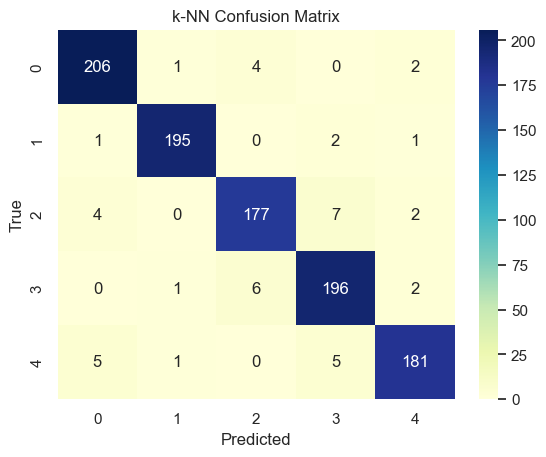

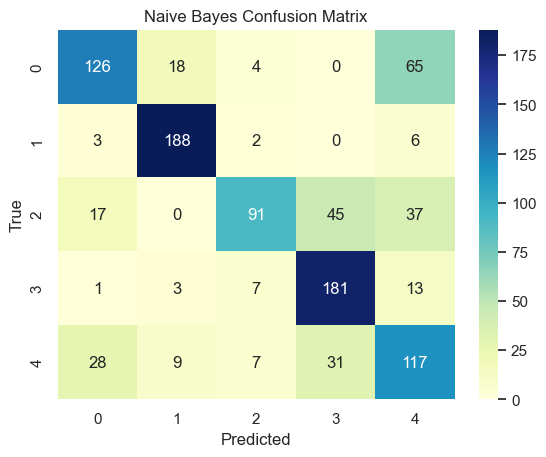

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm_knn, annot=True, cmap="YlGnBu", fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('k-NN Confusion Matrix')
plt.show()

sns.heatmap(cm_gnb, annot=True, cmap="YlGnBu", fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Naive Bayes Confusion Matrix')
plt.show()


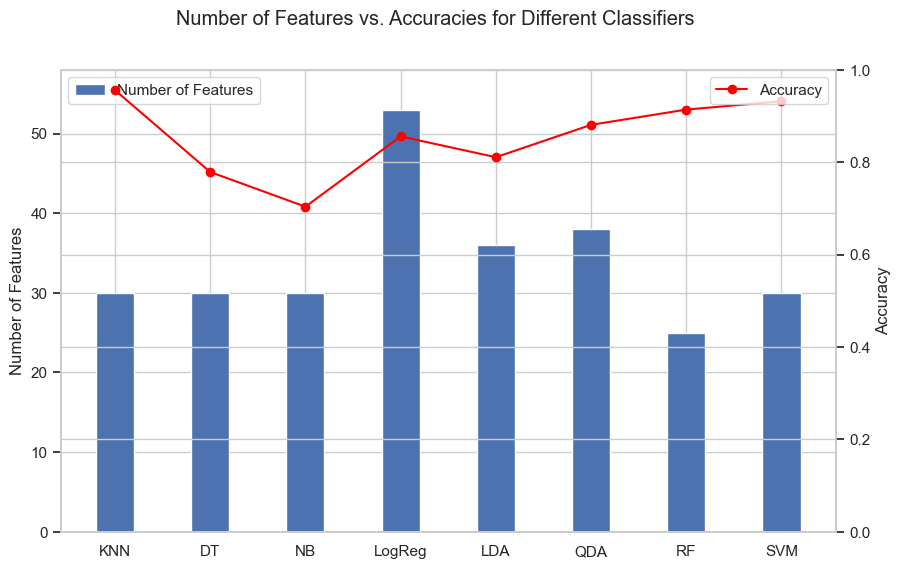

In [219]:
import matplotlib.pyplot as plt

# Prepare the data for plotting
classifiers = ['KNN', 'DT', 'NB', 'LogReg', 'LDA', 'QDA', 'RF', 'SVM']
num_features = [
    len(selected_features_KNN),
    len(selected_features_DT),
    len(selected_features_NB),
    len(selected_features_logreg),
    len(selected_features_LDA),
    len(selected_features_QDA),
    len(selected_features_RF),
    len(selected_features_SVM)
]
accuracies = [
    acc_knn,
    acc_dt,
    acc_gnb,
    acc_logreg,
    acc_lda,
    acc_qda,
    acc_rf,
    acc_svm
]

# Create the bar graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(classifiers, num_features, width=0.4, label='Number of Features')
ax.set_ylabel('Number of Features')
ax.set_ylim(0, max(num_features) + 5)

ax2 = ax.twinx()
ax2.plot(classifiers, accuracies, color='red', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)

# Add labels and legend
fig.suptitle('Number of Features vs. Accuracies for Different Classifiers')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


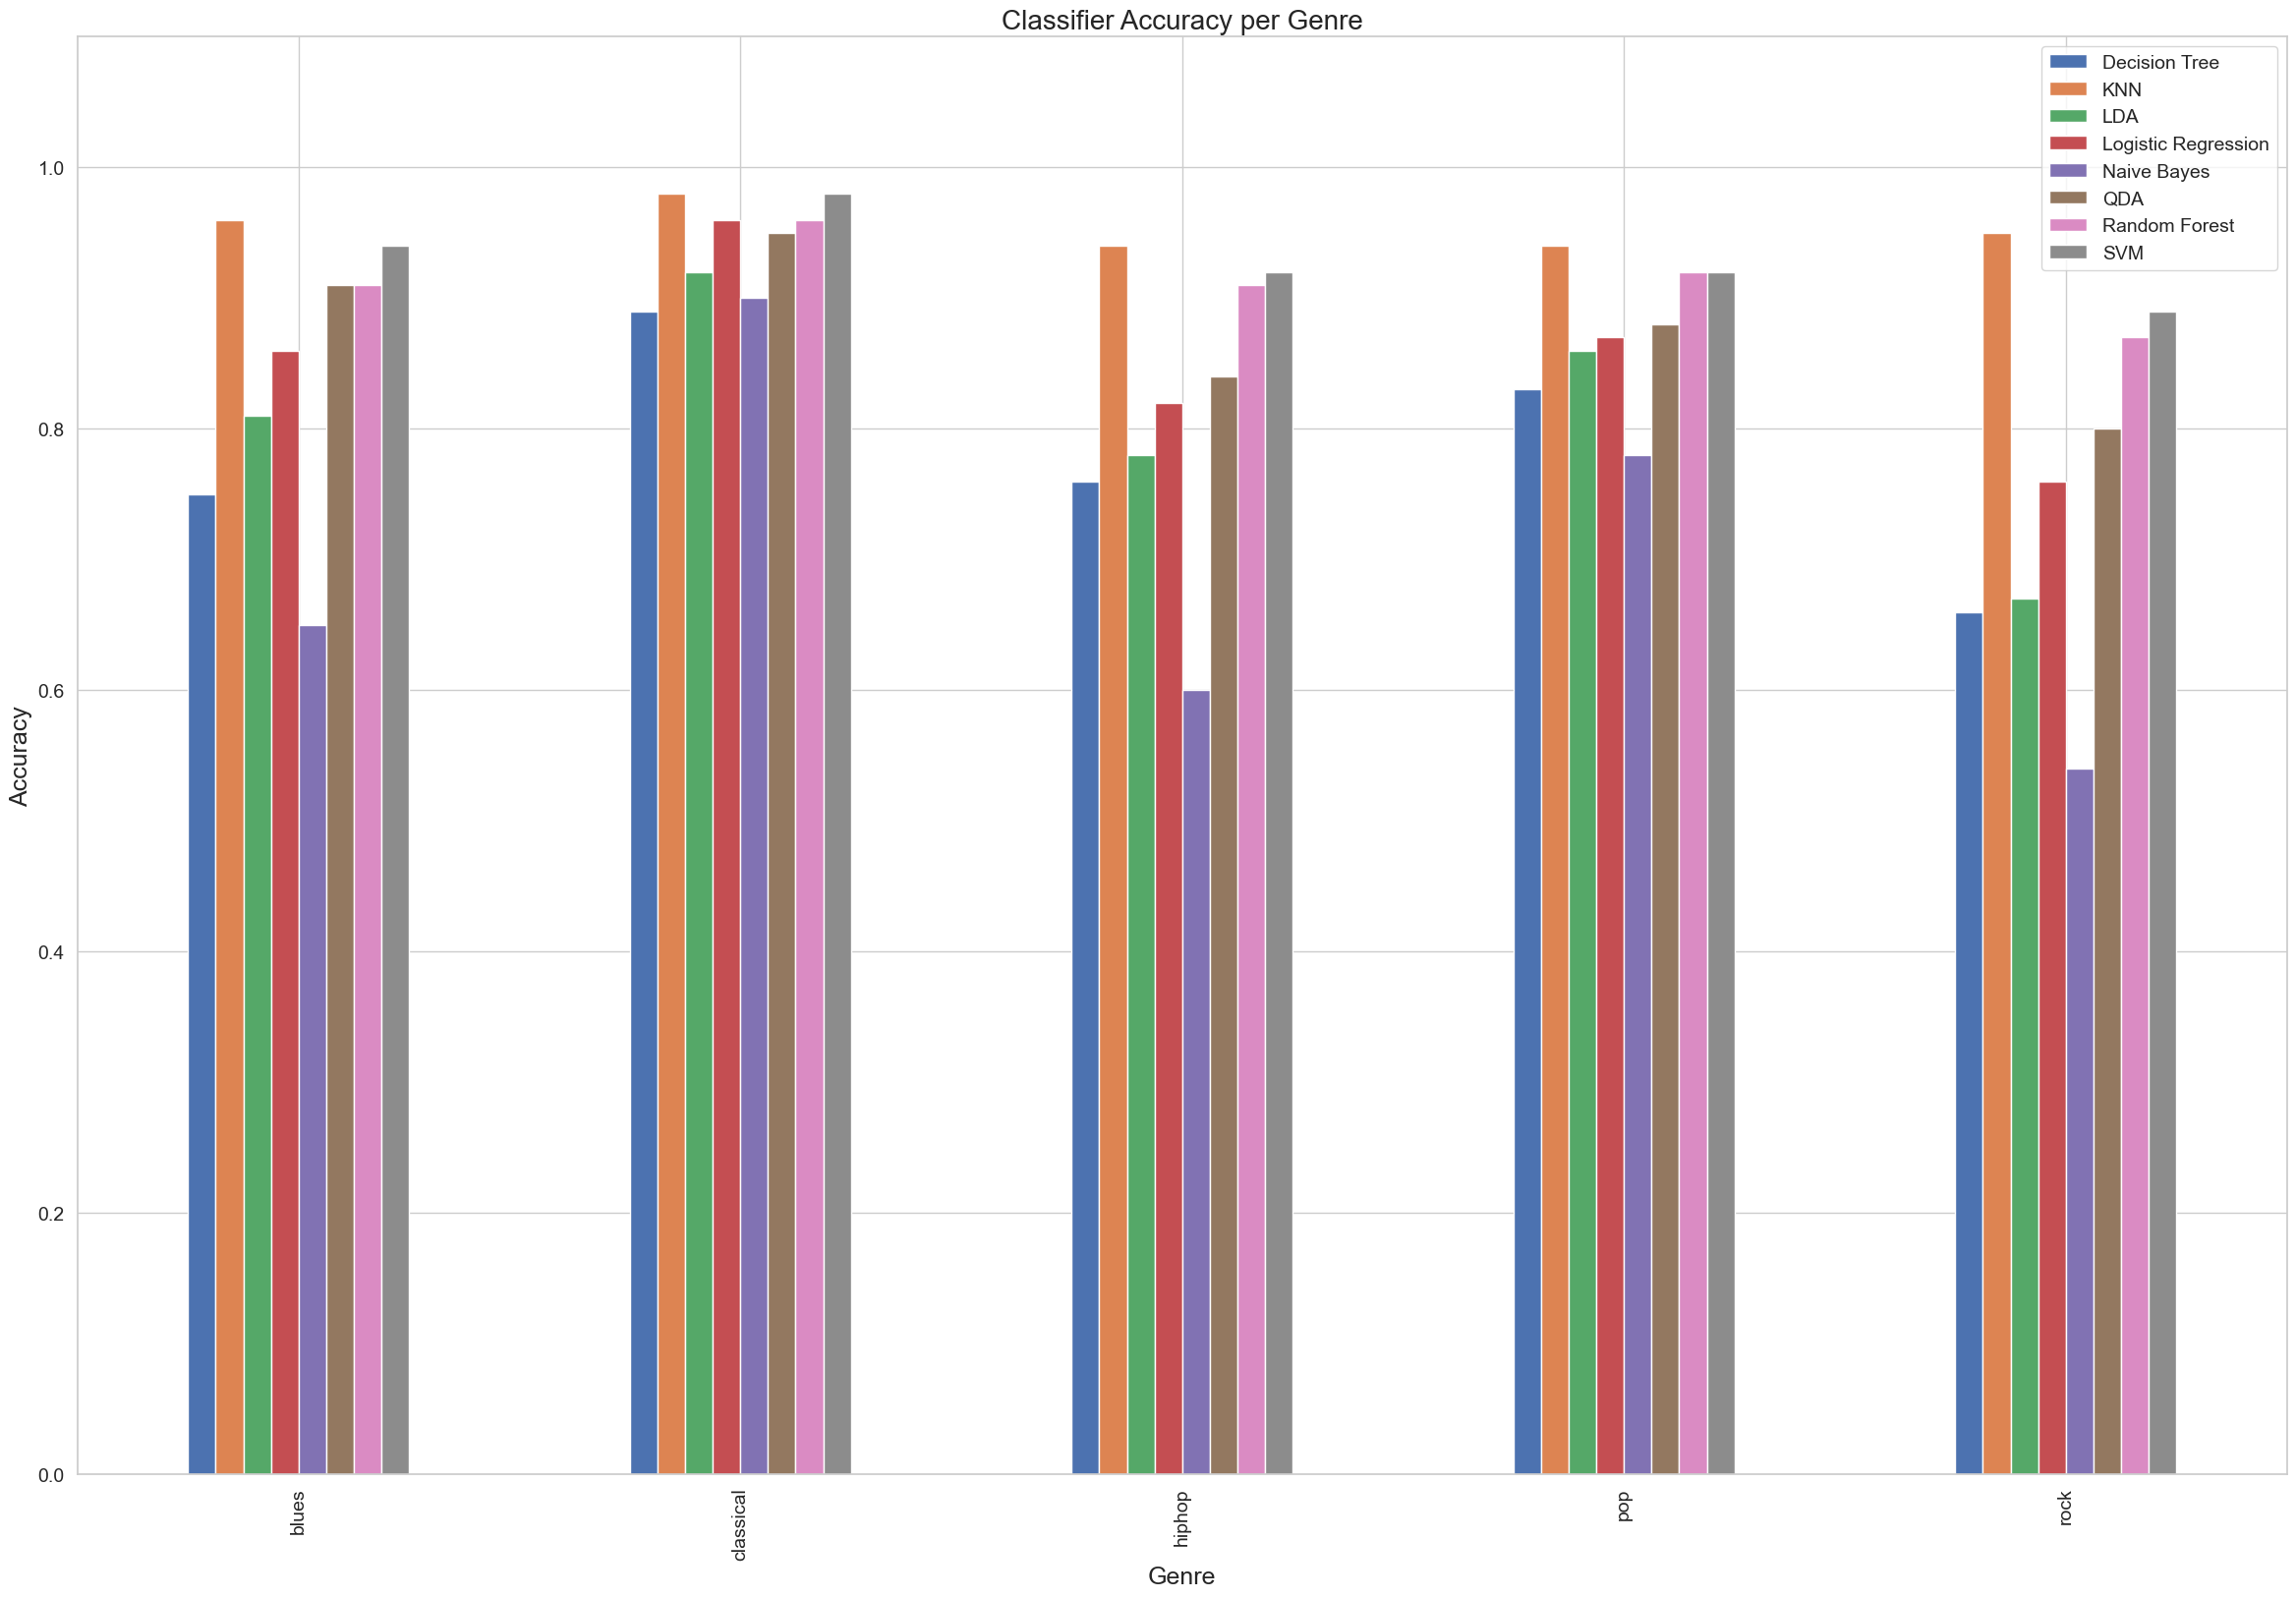

In [220]:
import pandas as pd
import matplotlib.pyplot as plt

def cr_to_dataframe(cr, classifier_name):
    lines = cr.split('\n')
    data = []
    for line in lines[2:-5]:
        if not line:
            continue
        row = line.split()
        data.append([row[0], float(row[-2]), classifier_name])
    return pd.DataFrame(data, columns=['Genre', 'Precision', 'Classifier'])

# Convert classification reports to dataframes
cr_gnb_df = cr_to_dataframe(cr_gnb, "Naive Bayes")
cr_knn_df = cr_to_dataframe(cr_knn, "KNN")
cr_dt_df = cr_to_dataframe(cr_dt, "Decision Tree")
cr_svm_df = cr_to_dataframe(cr_svm, "SVM")
cr_rf_df = cr_to_dataframe(cr_rf, "Random Forest")
cr_lda_df = cr_to_dataframe(cr_lda, "LDA")
cr_qda_df = cr_to_dataframe(cr_qda, "QDA")
cr_logreg_df = cr_to_dataframe(cr_logreg, "Logistic Regression")

# Combine all classification report dataframes into a single dataframe
all_cr_dfs = [cr_gnb_df, cr_knn_df, cr_dt_df, cr_svm_df, cr_rf_df, cr_lda_df, cr_qda_df, cr_logreg_df]
classifier_names = ["Naive Bayes", "KNN", "Decision Tree", "SVM", "Random Forest", "LDA", "QDA", "Logistic Regression"]

combined_df = pd.DataFrame()

for clf_name, cr_df in zip(classifier_names, all_cr_dfs):
    cr_df['Classifier'] = clf_name
    combined_df = pd.concat([combined_df, cr_df])

# Create a pivot table with 'Genre' as index, 'Classifier' as columns, and 'Precision' as values
pivot_df = combined_df.pivot_table(index='Genre', columns='Classifier', values='Precision')

# Plot the grouped bar chart
ax = pivot_df.plot(kind='bar', figsize=(29, 19))
ax.set_ylabel("Accuracy", fontsize=18)
ax.set_xlabel("Genre", fontsize=18)
ax.set_ylim([0, 1.1])
ax.tick_params(axis='both', labelsize=14)
plt.title("Classifier Accuracy per Genre", fontsize=20)
plt.legend(fontsize=14)
plt.show()


In [97]:
type(selected_features_KNN)

list

In [237]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def test_classifier(classifier, selected_features, test_data, scaler):
    # Scale the test data using the same scaler as the training data
    X_test_unscaled = test_data.iloc[:, :-1].values
    X_test_scaled = scaler.transform(X_test_unscaled)

    # Create a DataFrame with the scaled test data
    test_data_scaled_df = pd.DataFrame(X_test_scaled, columns=test_data.columns[:-1])

    # Extract the selected features and labels from the DataFrame
    X_test_selected = test_data_scaled_df[selected_features].to_numpy()  # Convert to NumPy array
    y_test_selected = test_data['label']

    # Use the classifier to make predictions on the test set
    y_pred = classifier.predict(X_test_selected)

    # Calculate the accuracy, confusion matrix, and classification report
    acc = accuracy_score(y_test_selected, y_pred)
    cm = confusion_matrix(y_test_selected, y_pred)
    cr = classification_report(y_test_selected, y_pred, zero_division=0)

    return acc, cm, cr

# Load the test_features.csv file into a DataFrame
test_data = pd.read_csv('/Users/ayush/Documents/Data/Test/test_features.csv')

# Store classifiers and their selected features in a dictionary
classifiers_features = {
    'KNN': (clf_knn, selected_features_KNN),
    'Decision Tree': (clf_dt, selected_features_DT),
    'SVM': (clf_svm, selected_features_SVM),
    'Logistic Regression': (clf_logreg, selected_features_logreg),
    'LDA': (clf_lda, selected_features_LDA),
    'QDA': (clf_qda, selected_features_QDA),
    'Random Forest': (clf_rf, selected_features_RF),
    'Naive Bayes': (clf_gnb, selected_features_NB)
}

# Initialize dictionaries to store accuracies and classification reports
accuracies = {}
classification_reports = {}

# Test each classifier and store the results
for name, (classifier, selected_features) in classifiers_features.items():
    accuracy, cm, cr = test_classifier(classifier, selected_features, test_data, scaler)
    accuracies[name] = accuracy
    classification_reports[name] = cr
    print(f"{name} accuracy on test set: {accuracy}")
    print(f"{name} confusion matrix:\n{cm}")
    print("\n")
#     print(f"{name} classification report:\n{cr}")


KNN accuracy on test set: 0.6576923076923077
KNN confusion matrix:
[[20  0 17  4 11]
 [ 1 50  0  1  0]
 [ 0  1 38 11  2]
 [ 1  1 11 26 13]
 [ 0  1  4 10 37]]


Decision Tree accuracy on test set: 0.7
Decision Tree confusion matrix:
[[27  1  6  1 17]
 [ 3 48  0  0  1]
 [ 0  0 43  6  3]
 [ 1  1 12 31  7]
 [ 7  1  1 10 33]]


SVM accuracy on test set: 0.7384615384615385
SVM confusion matrix:
[[23  0 16  2 11]
 [ 1 51  0  0  0]
 [ 0  1 47  3  1]
 [ 1  0 14 28  9]
 [ 2  0  4  3 43]]


Logistic Regression accuracy on test set: 0.7269230769230769
Logistic Regression confusion matrix:
[[24  3  7  0 18]
 [ 1 51  0  0  0]
 [ 0  1 45  5  1]
 [ 2  0 11 32  7]
 [ 6  1  8  0 37]]


LDA accuracy on test set: 0.7153846153846154
LDA confusion matrix:
[[22  8  7  0 15]
 [ 1 51  0  0  0]
 [ 0  1 44  4  3]
 [ 2  0 10 31  9]
 [ 6  1  6  1 38]]


QDA accuracy on test set: 0.7192307692307692
QDA confusion matrix:
[[21  1  4  1 25]
 [ 0 52  0  0  0]
 [ 0  1 36  8  7]
 [ 0  0 14 32  6]
 [ 2  1  1  2 46]]


Ran

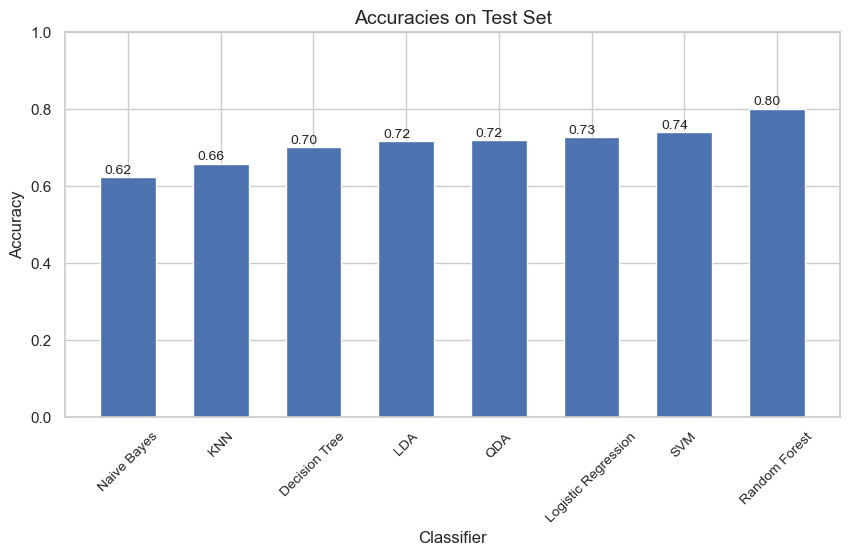

In [239]:
# Sort accuracies dictionary by value in ascending order
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1]))

# Plot the accuracies of all classifiers
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(sorted_accuracies))
width = 0.6

ax.bar(x, list(sorted_accuracies.values()), width)

ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracies on Test Set', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(list(sorted_accuracies.keys()), rotation=45, fontsize=10)
ax.set_ylim(0, 1)  # Set y-axis limit from 0 to 1

# Display accuracy values on top of each bar
for i, v in enumerate(sorted_accuracies.values()):
    ax.text(i - 0.25, v + 0.01, f'{v:.2f}', fontsize=10)

plt.show()


/var/folders/sc/_1ph4jld3y3gtyp1j08f98980000gn/T/ipykernel_17182/2936700487.py:33: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(12)


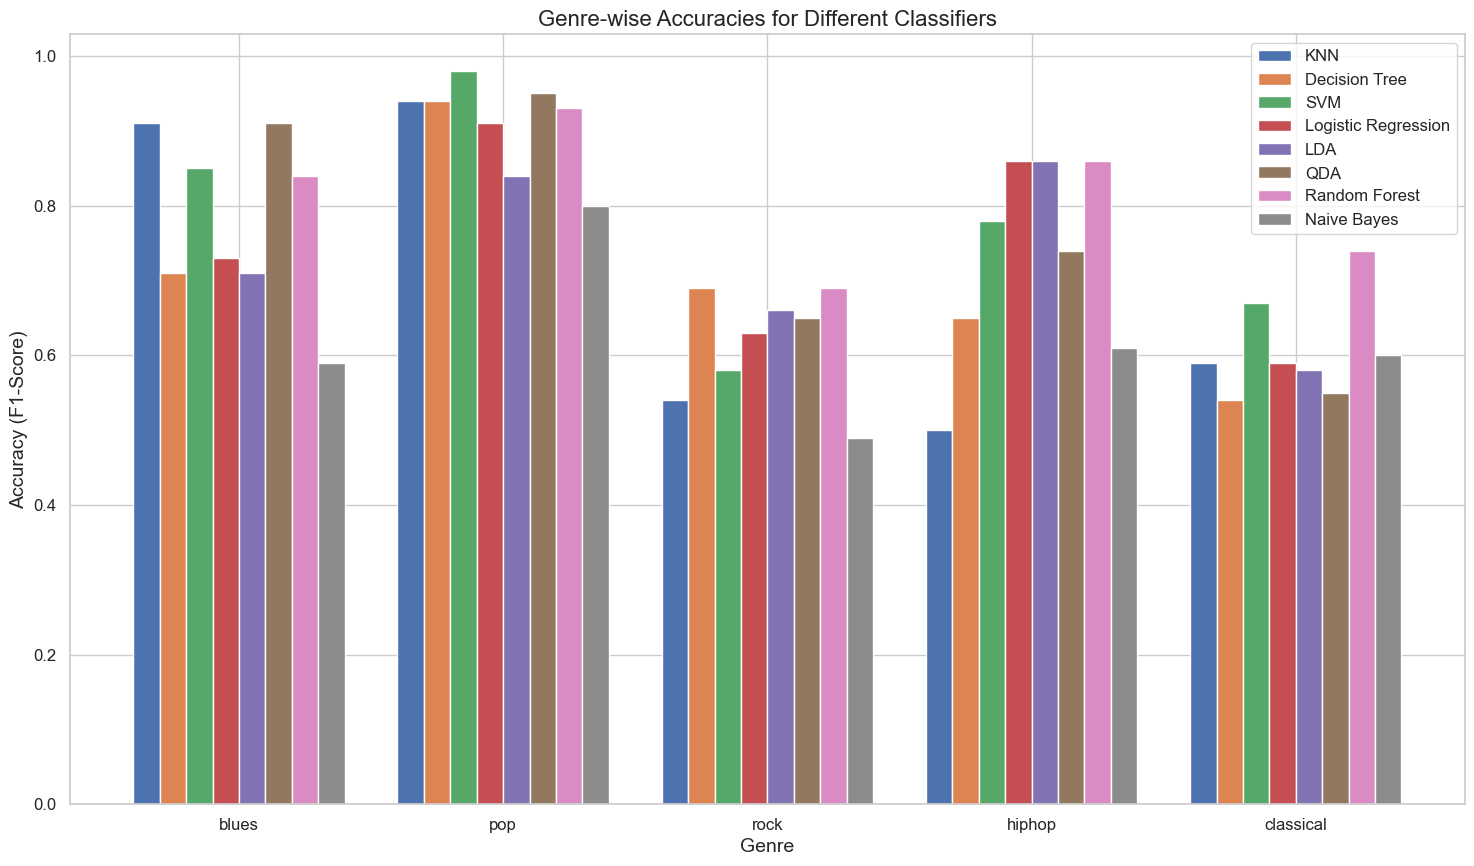

In [236]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score


# Extract genre-wise accuracies (precisions) from classification reports
genre_accuracies = {}
for name, cr in classification_reports.items():
    lines = cr.split('\n')
    genre_scores = []
    for line in lines[2:-5]:  # Skip the header and last few lines with summary info
        genre, precision, recall, f1, support = line.strip().split()
        genre_scores.append(float(precision))
    genre_accuracies[name] = genre_scores
# Plot genre-wise accuracies for each classifier
genres = list(test_data['label'].unique())
x = np.arange(len(genres))
width = 0.1
fig, ax = plt.subplots(figsize=(18, 10))  # Increase the overall size of the graph

for i, (name, genre_scores) in enumerate(genre_accuracies.items()):
    ax.bar(x + i * width, genre_scores, width, label=name)

ax.set_xlabel('Genre', fontsize=14)  # Increase the font size of the x-axis label
ax.set_ylabel('Accuracy (F1-Score)', fontsize=14)  # Increase the font size of the y-axis label
ax.set_title('Genre-wise Accuracies for Different Classifiers', fontsize=16)
ax.set_xticks(x + width * (len(classifiers_features) - 1) / 2)
ax.set_xticklabels(genres, fontsize=12)  # Increase the font size of the x-axis ticks
ax.legend(fontsize=12)  # Increase the font size of the legend

# Increase the font size of the y-axis ticks
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

plt.show()
